# Classifying Names with an CNN

In this notebook I'll implement another version of the name classifier using a [CNN](https://en.wikipedia.org/wiki/Convolutional_neural_network).

As before I'll load data preprocessing code from the [names module](https://github.com/bobflagg/classifying-names/blob/master/names.py) and training, evaluation and visualization code from the [util module](https://github.com/bobflagg/classifying-names/blob/master/util.py).

In [1]:
from names import NamesDataset, predict

batch_size = 16
dataset = NamesDataset(directory='./data/names/', verbose=False)
train_loader, test_loader = dataset.build_data_loaders(batch_size)
X, y = iter(train_loader).next()
seq_len, num_chars, num_classes = dataset.seq_len, dataset.num_chars, dataset.num_classes
languages = dataset.languages
print("Names batch shape/type:", X.shape, "/", X.dtype)
print("Labels batch shape/type:", y.shape, "/", y.dtype)

Names batch shape/type: torch.Size([16, 19, 57]) / torch.float32
Labels batch shape/type: torch.Size([16]) / torch.float32


In [2]:
%matplotlib inline

from util import get_accuracy, show_accuracy, show_confusion, train

## A CNN Classifier

PyTorch has a built-in [1-D CNN class](https://pytorch.org/docs/stable/nn.html#Conv1d).

In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F

In [4]:
class NameClassifierConv(nn.Module):
    def __init__(self, num_chars, out_channels, num_classes, dropout):
        super(NameClassifierConv, self).__init__()
        
        self.num_chars = num_chars
        self.out_channels = out_channels
        self.num_classes = num_classes
        self.dropout = dropout
        
        kernel_sizes = [1, 2, 3]
        n_kernels = len(kernel_sizes)
        self._convs = nn.ModuleList([
            nn.Conv1d(num_chars, out_channels, i) for i in kernel_sizes
        ])
        
        self.FC = nn.Linear(n_kernels * out_channels, num_classes)
    
    def forward(self, X):
        # transforms X to dimensions: batch-size x in-channels x seq-len
        conv_in = X.transpose(1, 2)
        
        output = torch.cat(
            [conv(conv_in).max(dim=2)[0] for conv in self._convs], 
            dim=1
        )
        output = F.dropout(output, self.dropout, training=self.training)
        output = self.FC(output)
        
        return output.view(-1, self.num_classes) # batch_size X n_output

In [5]:
model = NameClassifierConv(num_chars, 128, num_classes, 0.4)
if torch.cuda.is_available(): model.cuda()
print(model)

NameClassifierConv(
  (_convs): ModuleList(
    (0): Conv1d(57, 128, kernel_size=(1,), stride=(1,))
    (1): Conv1d(57, 128, kernel_size=(2,), stride=(1,))
    (2): Conv1d(57, 128, kernel_size=(3,), stride=(1,))
  )
  (FC): Linear(in_features=384, out_features=18, bias=True)
)


In [6]:
import torch.optim as optim

def train(
    model, 
    train_loader, 
    test_loader, 
    batch_size, 
    seq_len, 
    num_chars, 
    num_classes, 
    epochs, 
    lr=0.001
):
    train_on_gpu = torch.cuda.is_available()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    all_train_acc = [1.0 / num_classes]
    all_test_acc = [1.0 / num_classes]

    for epoch in range(epochs):
        train_running_loss = 0.0
        train_acc = 0.0
        model.train()

        for i, data in enumerate(train_loader):
            optimizer.zero_grad()
            inputs, labels = data
            if(train_on_gpu): inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)

            loss = criterion(outputs, labels.long())
            loss.backward()
            optimizer.step()

            train_running_loss += loss.detach().item()
            train_acc += get_accuracy(outputs, labels, batch_size)

        model.eval()
        epoch_loss = train_running_loss / i
        epoch_train_acc = train_acc / i
        all_train_acc.append(epoch_train_acc)

        test_acc = 0.0
        for i, data in enumerate(test_loader, 0):
            inputs, labels = data
            if(train_on_gpu): inputs, labels = inputs.cuda(), labels.cuda()
            #inputs = inputs.view(-1, seq_length, num_chars) 
            outputs = model(inputs)
            test_acc += get_accuracy(outputs, labels, batch_size)
        epoch_test_acc = test_acc / i
        all_test_acc.append(epoch_test_acc)
        print(
            'Epoch:  %2d | Loss: %03.2f | Train Accuracy: %.2f | Test Accuracy: %.2f' %
            (epoch + 1, epoch_loss, epoch_train_acc, epoch_test_acc)
        )
    return all_test_acc, all_train_acc


In [7]:
%%time
test_acc, train_acc = train(
    model, 
    train_loader,
    test_loader,
    batch_size, 
    seq_len, 
    num_chars, 
    num_classes, 
    epochs=16, 
    lr=0.003
)

Epoch:   1 | Loss: 1.05 | Train Accuracy: 69.07 | Test Accuracy: 78.78
Epoch:   2 | Loss: 0.69 | Train Accuracy: 78.84 | Test Accuracy: 80.97
Epoch:   3 | Loss: 0.60 | Train Accuracy: 80.91 | Test Accuracy: 82.54
Epoch:   4 | Loss: 0.56 | Train Accuracy: 82.00 | Test Accuracy: 82.90
Epoch:   5 | Loss: 0.53 | Train Accuracy: 82.86 | Test Accuracy: 82.78
Epoch:   6 | Loss: 0.51 | Train Accuracy: 83.63 | Test Accuracy: 83.42
Epoch:   7 | Loss: 0.49 | Train Accuracy: 84.14 | Test Accuracy: 83.14
Epoch:   8 | Loss: 0.48 | Train Accuracy: 84.16 | Test Accuracy: 83.81
Epoch:   9 | Loss: 0.47 | Train Accuracy: 84.59 | Test Accuracy: 83.73
Epoch:  10 | Loss: 0.46 | Train Accuracy: 84.78 | Test Accuracy: 83.48
Epoch:  11 | Loss: 0.45 | Train Accuracy: 84.89 | Test Accuracy: 83.65
Epoch:  12 | Loss: 0.44 | Train Accuracy: 85.26 | Test Accuracy: 84.42
Epoch:  13 | Loss: 0.44 | Train Accuracy: 85.24 | Test Accuracy: 83.73
Epoch:  14 | Loss: 0.44 | Train Accuracy: 85.32 | Test Accuracy: 83.58
Epoch:

The accuracy is about 84%, competitive with the LSTM model. Below is the learning curves plot, confusion matrics and predictions example.

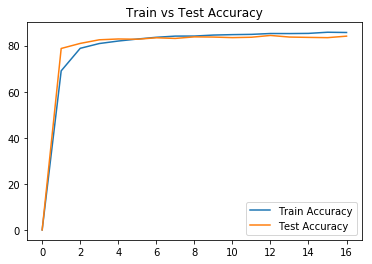

In [8]:
show_accuracy(model, test_acc, train_acc)

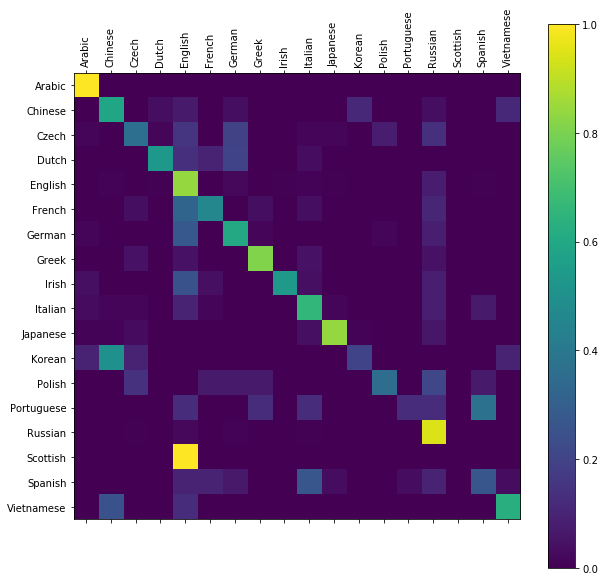

In [9]:
show_confusion(model, test_loader, languages, seq_len, num_chars)

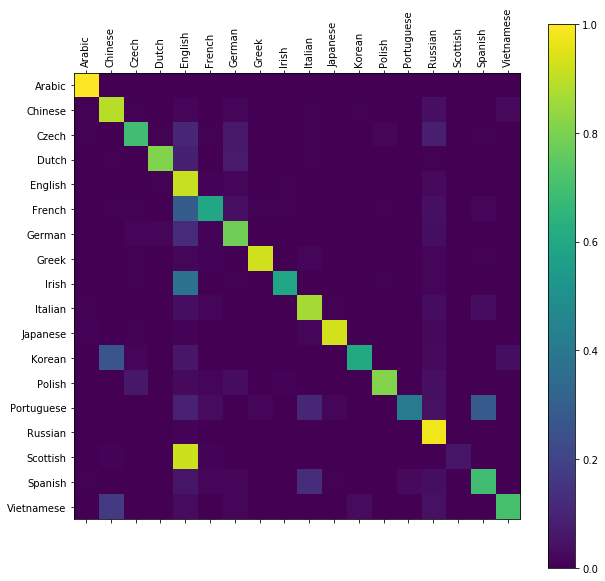

In [10]:
show_confusion(model, train_loader, languages, seq_len, num_chars)

In [11]:
for name in ['Dovesky', 'Jackson', 'Satoshi']:
    print(name, '-->>', predict(dataset, model, name, rnn=False))

Dovesky -->> Russian
Jackson -->> English
Satoshi -->> Japanese
